# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [1]:
!git clone https://github.com/DataHow/analytics-course-scripts.git
!pip install --upgrade scipy==1.7.3

Cloning into 'analytics-course-scripts'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 183 (delta 94), reused 141 (delta 52), pack-reused 0
Receiving objects: 100% (183/183), 946.59 KiB | 15.78 MiB/s, done.
Resolving deltas: 100% (94/94), done.
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# import libaries
import pandas as pd
import numpy as np
import scipy
import importlib  
import scipy.integrate
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, explained_variance_score

# import custom modules
emulator = importlib.import_module("analytics-course-scripts.scripts.modules.emulator")
modelhelpers = importlib.import_module("analytics-course-scripts.scripts.modules.modelhelpers")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import or Generate Dataset

In the beginning of each notebook you can make a decision whether you run the notebooks with already pre-generated runs which will be just imported or you will generate your own doe dataset from insilico model. For further information about the process emulator for cell culture fed-batch processes, check the script "00_Process_Characterization.ipynb" or the Powerpoint presentation "Simplified InSilico Model.pptx".

* For dataset import set `select_dataset_source = "import"`.
* For generating data set `select_dataset_source = "generate"`.

For first time running the notebook, we recommend choosing the "import" option.

 

In [3]:
# Select dataset source
select_dataset_source = "import"

In [4]:
if select_dataset_source == "import":
    # Define filename to import
    filename = "owu.csv"
    filepath = "/content/analytics-course-scripts/scripts/datasets/"
    # Import OWU Train data
    owu = pd.read_csv(filepath+filename,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu.index = pd.MultiIndex.from_product([list(range(int(len(owu)/15))),list(range(15))], names=["run","time"])
    doe = pd.read_csv(filepath+filename.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])
    # Import OWU Test data
    filename = "owu_test.csv"
    owu_test = pd.read_csv(filepath+filename,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu_test.index = pd.MultiIndex.from_product([list(range(int(len(owu_test)/15))),list(range(15))], names=["run","time"])
    doe_test = pd.read_csv(filepath+filename.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])


In [5]:
if select_dataset_source == "generate":
    # Model parameters
    mu_g_max = 0.05;
    mu_d_max = 0.025;
    K_g_Glc  = 1;
    K_I_Lac  = 30;
    K_d_Lac  = 50;
    k_Glc    = 0.04;
    k_Lac    = 0.06;
    k_Prod   = 1;

    # Process parameters
    feed_start = [1, 4]
    feed_end = [8, 12]
    Glc_feed_rate = [5, 20]
    Glc_0 = [10, 80.0]
    VCD_0 = [0.1, 1.0]

    var_lims = {"mu_g_max":mu_g_max,"mu_d_max": mu_d_max,"K_g_Glc" : K_g_Glc,"K_I_Lac" : K_I_Lac,"K_d_Lac" : K_d_Lac,"k_Glc" : k_Glc,"k_Lac" : k_Lac,"k_Prod" : k_Prod,"feed_start" : feed_start, "feed_end" : feed_end,"Glc_feed_rate" : Glc_feed_rate, "Glc_0" : Glc_0, "VCD_0" : VCD_0}

    # Define the number of experiments
    num_runs = 50
    # Define the filename for the dataset
    filename = "owu.csv"
    filepath = "/content/"
    # Generate Dataset
    owu = emulator.generate_data(var_lims, num_runs, filename)
    # Import OWU
    owu = pd.read_csv(filepath+filename,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu.index = pd.MultiIndex.from_product([list(range(num_runs)),list(range(15))], names=["run","time"])
    # Import DOE
    doe = pd.read_csv(filepath+filename.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])

# Regression Modelling

In this section, we first create load the train experiments that were create inthe PCA script and save in the file "Experiment_Train_Set.mat". 
These experimental data will be used to create a MLR model to predict final titer, which will serve as term of comparison for the PLS model trained below.

# Initial Conditions model

From OWU train and test dataset we create BWU data, DOE data and Target data.
DOE data contains the inditial parameter conditions (or Z variable) for the experiments.
Target data contain just the final values of Titer at day 14 (or Aggregates).

In [6]:
# Train set
bwu = emulator.generate_bwu(owu)
tar = emulator.generate_y(bwu,return_aggr=False)
# Test set
bwu_test = emulator.generate_bwu(owu_test)
tar_test = emulator.generate_y(bwu_test,return_aggr=False)

In [7]:
# Visualize input data
doe

,feed_start,feed_end,Glc_feed_rate,Glc_0,VCD_0
0,2.500000,10.000000,12.500000,45.000000,0.550000
1,1.948980,10.244898,18.622449,40.714286,0.274490
2,3.295918,9.346939,14.642857,17.857143,0.127551
3,3.479592,9.020408,15.561224,47.857143,0.843878
4,1.459184,9.591837,7.295918,33.571429,0.421429
5,3.418367,9.265306,8.214286,45.000000,0.403061
6,1.153061,8.448980,17.091837,67.857143,0.862245
7,2.438776,8.122449,14.336735,10.714286,0.898980
8,2.744898,11.551020,9.132653,27.857143,0.292857
9,2.316327,9.183673,5.459184,75.000000,0.256122


In [8]:
# Visualize Target data
tar

,Y:Prod
0,1565.310032
1,854.449233
2,1206.096655
3,1587.937536
4,811.552990
5,841.498708
6,645.865240
7,978.321190
8,1026.259363
9,1307.342791


## Multiple Linear Regression 

We first train/fit a quadratic MLR model to the final titer, using the data loaded above.
We then characterize the performance of the model using ANOVA, where the user can have information about the importance of each coefficient and of the overal model.

### Create linear model with preprocessing

Here we create a linear model to predict the value of the final titer given the initial conditions.

* Input matrix: "doe". This corresponds to the values of the manipulated process parameters for each experiment.
* Output target: "tar". This corresponds to the final value of titer at the end of each experiment. (or aggregates)

In [9]:
# Fit Linear Model
datascaler = StandardScaler()
does = datascaler.fit_transform(doe.values)

X = sm.add_constant(does)
y = tar.values
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     3.240
Date:                Wed, 27 Apr 2022   Prob (F-statistic):             0.0141
Time:                        08:36:44   Log-Likelihood:                -357.18
No. Observations:                  50   AIC:                             726.4
Df Residuals:                      44   BIC:                             737.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1153.5475     46.179     24.980      0.0

### Evaluate model prediction on train set and model inference


In this section, we check the predictions of the models versus the training data for the final titer.


In [16]:
# Use data normalization
use_norm = True
# Use bias term
use_bias = True
# Use polynomial features of degree
use_degree = 2
# Use only interaction terms form higher degree polynomial features
use_inter = True

In [17]:
# Define pipeline
pfeatures = PolynomialFeatures(degree=use_degree,interaction_only=use_inter, include_bias=use_bias)
pscaler = StandardScaler(with_mean=use_norm,with_std=use_norm)
lm = LinearRegression()
pipe = Pipeline([('features', pfeatures),('scaler', pscaler), ('model', lm)])
# Fit model
X = doe
y = tar
pipe.fit(X,y)

Pipeline(steps=[('features', PolynomialFeatures(interaction_only=True)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [18]:
# Model coefficients
columns = pfeatures.get_feature_names_out()
coefficients = lm.coef_
fig = px.bar(x=list(columns),y=coefficients.reshape(-1),title="Linear model coefficients")
fig.show()

### Evaluate model prediction on train and test set

In [19]:
# Plot predictions in train set
yhat = pipe.predict(X)
fig = px.scatter(x=y.values.reshape(-1),y=yhat.reshape(-1), title="Observed vs Predicted on Train Set; R^2 = "+str(round(pipe.score(X,y),3)), labels=dict(x="Observed Titer", y="Predicted Titer"))
fig.update_layout(shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 1, 'x0': 0, 'x1': 1, 'layer': 'below'}])
fig.show()
# Plot predictions in test set
X_test = doe_test
y_test = tar_test
yhat_test = pipe.predict(X_test)
fig = px.scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1), title="Observed vs Predicted on Test Set; R^2 = "+str(round(pipe.score(X_test,y_test),3)), labels=dict(x="Observed Titer", y="Predicted Titer"))
fig.update_layout(shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 1, 'x0': 0, 'x1': 1, 'layer': 'below'}])
fig.show()

In [20]:
# Absolute RMSEP
rmse_abs = mean_squared_error(y_test, yhat_test,squared=False)
print('Absolute RMSEP: ',rmse_abs)
# Relative RMSEP
rmse_rel = mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test))
print('Relative RMSEP: ',rmse_rel)

Absolute RMSEP:  282.4383189173625
Relative RMSEP:  0.9769849462682716


## PLS Model

In this section, we train a PLS model with the data loaded in the section above.


### Create a PLS model with specific latent variables

Create a PLS model to predict the value of the final titer given the initial conditions.

* Input matrix: "doe". This corresponds to the values of the manipulated process parameters for each experiment.
* Output target: "tar". This corresponds to the final value of titer at the end of each experiment. (or aggregates)

Select the number of latent variables for the model (the maximum number of latent variables is 5, equal to the number of variables in the input matrix).





In [21]:
# Use data normalization
use_norm = True
# Number of latent variables
N_LV = 5

In [22]:
# Define Pipeline
pscaler = StandardScaler(with_mean=use_norm,with_std=use_norm)
pls = PLSRegression(n_components=N_LV)
pipe = Pipeline([('scaler', pscaler), ('model', pls)])
# Train PLS model
X = doe
y = tar
pipe.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', PLSRegression(n_components=5))])

### Evaluate model on train and test set


In [23]:
# Plot predictions in train set
yhat = pipe.predict(X)
fig = px.scatter(x=y.values.reshape(-1),y=yhat.reshape(-1), title="Observed vs Predicted on Train Set; R^2 = "+str(round(pipe.score(X,y),3)), labels=dict(x="Observed Titer", y="Predicted Titer"))
fig.update_layout(shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 1, 'x0': 0, 'x1': 1, 'layer': 'below'}])
fig.show()
# Plot predictions in test set
X_test = doe_test
y_test = tar_test
yhat_test = pipe.predict(X_test)
fig = px.scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1), title="Observed vs Predicted on Test Set; R^2 = "+str(round(pipe.score(X_test,y_test),3)), labels=dict(x="Observed Titer", y="Predicted Titer"))
fig.update_layout(shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 1, 'x0': 0, 'x1': 1, 'layer': 'below'}])
fig.show()

In [24]:
# Absolute RMSEP
rmse_abs = mean_squared_error(y_test, yhat_test,squared=False)
print('Absolute RMSEP: ',rmse_abs)
# Relative RMSEP
rmse_rel = mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test))
print('Relative RMSEP: ',rmse_rel)

Absolute RMSEP:  339.0945364710543
Relative RMSEP:  1.17296498139464


### Plot variance explained in the Y

Similarly as in PCA script, we can look at explained variance by the principal components. However the difference being that in PCA we are trying to maximize the variance explained. In PLS we are trying to maximize the covarinace with the target.

In [25]:
# Plot Explained Variance plots
scores = pls.x_scores_
expl_var = np.var(scores, axis=0)
expl_var_ratio = expl_var / np.sum(expl_var)
fig = px.line(x=list(range(N_LV)), y=np.cumsum(expl_var_ratio), color=px.Constant("Cumulative explained variance"), labels=dict(x="Principal component index", y="Explained Variance Ratio", color="Legend"))
fig.add_bar(x=list(range(N_LV)), y=expl_var_ratio, name="Individual explained variance")
fig.show()


In [40]:
# Principal component on x-axis
select_x_pca = 1
# Principal component on y-axis
select_y_pca = 2

In [41]:
# Plot loadings
loadings = pls.x_loadings_
fig = px.scatter(x=pls.x_scores_[:,select_x_pca-1],y=pls.x_scores_[:,select_y_pca-1])
for i, feature in enumerate(doe.columns):
    fig.add_shape(type='line', x0=0, y0=0, x1=loadings[i,select_x_pca-1], y1=loadings[i,select_y_pca-1])
    fig.add_annotation(x=loadings[i,select_x_pca-1], y=loadings[i,select_y_pca-1], ax=0, ay=0, xanchor="center", yanchor="bottom", text=feature)
fig.show()

### Plot VIP scores

In [39]:
# Model coefficients
columns = X.columns
coefficients = vip(X,y,pls)
fig = px.bar(x=list(columns),y=coefficients.reshape(-1),title="Variable Importance in PLS")
fig.show()


### Task: 
1. What number of latent variables produces best model?

# Historical PLS Model

In an so-called historical model, the data from different experiments are ordered into a batch-wise unfolded (BWU) matrix (i.e., every row corresponds to an experiment).

The BWU can be used to compute final properties of the experiment, like CQAs, which are typically the effect of the cumulated effect of the experiment profile.

In this example, we will use the BWU matrix to predict the final value of titer. Clearly, titer information are removed from the BWU matrix.

### Create BWU matrix

Here the BWU matrix is created. The vaues of the manipulated variables are added as columns at the beginning of the matrix. The following pre-processing was performed.

* Remove titer
* Remove exceeding days
* Eliminate invariant columns
* Remove linearly dependent columns
* Add process parameters at the beginning
* Create a PLS model from the initial design to the final titer


In [98]:
# Define number of days to include
N_days = 13

In [114]:
X = bwu
remove_columns = []
# Remove X:Titer 
remove_columns.extend([c for c in bwu.columns if c.startswith('X:Titer')])
# Remove X:Lactate
remove_columns.extend([c for c in bwu.columns if c.startswith('X:Lac')])
# Remove W:Feed
remove_columns.extend([c for c in bwu.columns if c.startswith('W:Feed')])
# Remove Initial conditions
remove_columns.extend([c for c in bwu.columns if c.endswith(':0')])
# Remove exceeding days
for d in range(N_days,15):
    remove_columns.extend([c for c in bwu.columns if c.endswith(":"+str(d))])
# Remove invariant 
remove_columns.extend(list(bwu.columns[~(bwu != bwu.iloc[0]).any().values]))

# Add and remove columns
X = X.drop(set(remove_columns),axis=1)
X = pd.concat([doe, X], axis=1)

X.columns

Index(['feed_start', 'feed_end', 'Glc_feed_rate', 'Glc_0', 'VCD_0', 'X:VCD:1',
       'X:VCD:2', 'X:VCD:3', 'X:VCD:4', 'X:VCD:5', 'X:VCD:6', 'X:VCD:7',
       'X:VCD:8', 'X:VCD:9', 'X:VCD:10', 'X:VCD:11', 'X:VCD:12', 'X:Glc:1',
       'X:Glc:2', 'X:Glc:3', 'X:Glc:4', 'X:Glc:5', 'X:Glc:6', 'X:Glc:7',
       'X:Glc:8', 'X:Glc:9', 'X:Glc:10', 'X:Glc:11', 'X:Glc:12'],
      dtype='object')

### Train Historical PLS model

In [101]:
# Define number of latent variables
N_LV = 5
# Use data normalization
use_norm = True

In [102]:
# Define Pipeline
pscaler = StandardScaler(with_mean=use_norm,with_std=use_norm)
pls = PLSRegression(n_components=N_LV)
pipe = Pipeline([('scaler', pscaler), ('model', pls)])
# Train PLS model
y = tar
pipe.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', PLSRegression(n_components=5))])

### Evaluate model on train and test set




In [105]:
# Plot predictions in train set
yhat = pipe.predict(X)
fig = px.scatter(x=y.values.reshape(-1),y=yhat.reshape(-1), title="Observed vs Predicted on Train Set; R^2 = "+str(round(pipe.score(X,y),3)), labels=dict(x="Observed Titer", y="Predicted Titer"))
fig.update_layout(shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 1, 'x0': 0, 'x1': 1, 'layer': 'below'}])
fig.show()
# Plot predictions in test set
X_test = bwu_test
y_test = tar_test
X_test = X_test.drop(set(remove_columns),axis=1)
X_test = pd.concat([doe_test, X_test], axis=1)
yhat_test = pipe.predict(X_test)
fig = px.scatter(x=y_test.values.reshape(-1),y=yhat_test.reshape(-1), title="Observed vs Predicted on Test Set; R^2 = "+str(round(pipe.score(X_test,y_test),3)), labels=dict(x="Observed Titer", y="Predicted Titer"))
fig.update_layout(shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 1, 'x0': 0, 'x1': 1, 'layer': 'below'}])
fig.show()

In [115]:
# Absolute RMSEP
rmse_abs = mean_squared_error(y_test, yhat_test,squared=False)
print('Absolute RMSEP: ',rmse_abs)
# Relative RMSEP
rmse_rel = mean_squared_error(y_test, yhat_test,squared=False) / np.std(np.array(y_test))
print('Relative RMSEP: ',rmse_rel)

Absolute RMSEP:  44.912690726879084
Relative RMSEP:  0.1553578951494958


In [110]:
# Plot loadings
loadings = pls.x_loadings_
#fig = px.scatter(x=pls.x_scores_[:,select_x_pca-1],y=pls.x_scores_[:,select_y_pca-1])
fig = px.scatter(x=[0,0], y=[0,0])
for i, feature in enumerate(X.columns):
    fig.add_shape(type='line', x0=0, y0=0, x1=loadings[i,select_x_pca-1], y1=loadings[i,select_y_pca-1])
    fig.add_annotation(x=loadings[i,select_x_pca-1], y=loadings[i,select_y_pca-1], ax=0, ay=0, xanchor="center", yanchor="bottom", text=feature)
fig.show()

In [111]:
# Model coefficients
columns = X.columns
coefficients = vip(X,y,pls)
fig = px.bar(x=list(columns),y=coefficients.reshape(-1),title="Variable Importance in PLS")
fig.show()

## Simulate Cross Validation



### Compute cross validation

In this section, we will simulate a typical cross- validation to define the optimal number of latent variables.


Nfold PLS1 models are trained using (Nfolds-1) folds. For each model, the sum of squared residuals (SSR) is calculated and summed up.

This is repeated for different numbers of latent variables. The number of latent variables returning the least value of the SSRs is chosen as optimal.
A second criterion is selected, namely the Bayesian Information Criterion (BIC), which is weighting the effect of the number of latent variables, i.e., if two values of the number of latent variables are returning a similar value of the SSR, then the one using less variables is chosen to be more likely to produce robust predictions.:


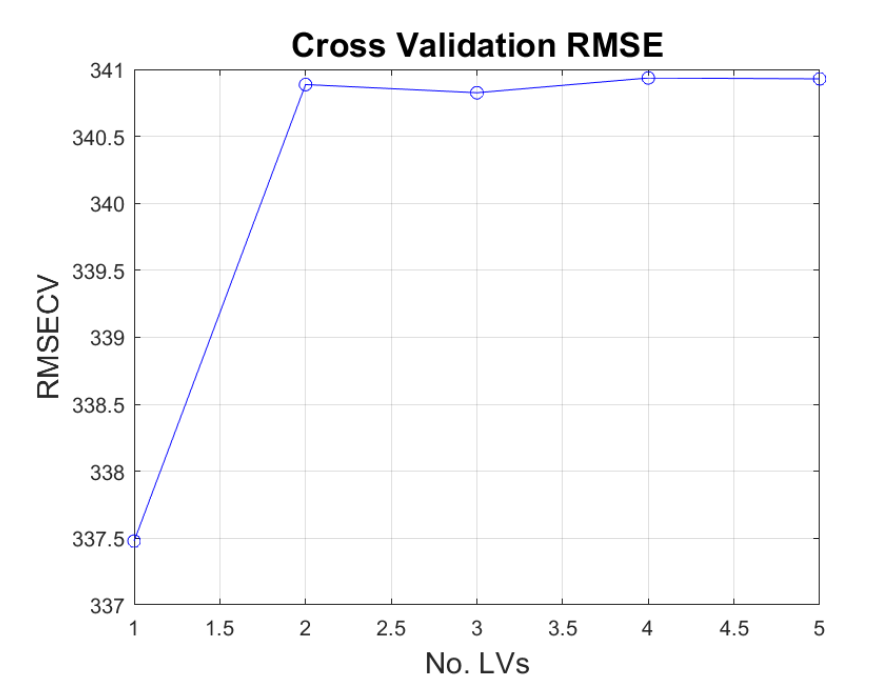

In [ ]:
# plot obs vs predicted, compute abs/rel rmse

### Plot scores, loadings and VIP

In [ ]:
# plot bi-plot / scores / loadings / VIP values

### Task: Check model diagnostics

In [ ]:
# Residuals, mahalanobis distances